In [1]:
'''
Import packages 
'''

%matplotlib inline

from sklearn.datasets import fetch_openml # Import MNIST from a Package
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Standard PyTorch Imports
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import DataLoader,random_split
from PIL import Image 
import skimage

# We will be using the PyTorch Wrapper Framework skorch to help simplify the coding
from skorch import NeuralNetClassifier
from torchvision import datasets

# If CUDA is available, use CUDA or else default to CPU.
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Setting a seed for torch
torch.manual_seed(0)

In [2]:
'''
Import the data
'''
from torch.nn.functional import normalize
from torch.utils.data import DataLoader
# select the root = ....

mnist = torchvision.datasets.MNIST(root = '/data', 
                                   train = True, 
                                   transform = transforms.ToTensor(),  
                                   download = True)

test_dataset = torchvision.datasets.MNIST(root = '/data', 
                                          train = False, 
                                          transform = transforms.ToTensor())




x_train = mnist.data
y_train = mnist.targets

# x_valid = valid_data.data
# y_valid = valid_data.targets

test_data = test_dataset.data
test_targets = test_dataset.targets

# x_test = test_dataset.data
# y_test = test_dataset.targets
print(list(x_train.size()))

'''
Step -- Normalize each input from [0.0,1.0] range
'''

x_train_norm = torch.nn.functional.normalize(x_train.float())
# x_valid_norm = torch.nn.functional.normalize(x_train.float())
test_norm = torch.nn.functional.normalize(test_data.float())

m=len(test_dataset)
x_valid, x_test = random_split(test_norm, [int(m-m*0.5), int(m*0.5)])
y_valid, y_test = random_split(test_targets, [int(m-m*0.5), int(m*0.5)])


print(x_train_norm.dim())

#create salt and pepper noise set
x_train_sp = skimage.util.random_noise(x_train_norm, mode = 's&p')
x_valid_sp = skimage.util.random_noise(x_valid[0], mode = 's&p')

#create gaussian noise set
x_train_gn = skimage.util.random_noise(x_train_norm, mode = 'gaussian')
x_valid_gn = skimage.util.random_noise(x_valid[0], mode = 'gaussian')


'''
Step -- Reshape X to have 4 dimension that is channels, Height, Width, batch_size, 
'''


batch_size=256

x_train_loader = torch.utils.data.DataLoader(x_train_norm, batch_size=batch_size)
y_train_loader = torch.utils.data.DataLoader(y_train, batch_size=batch_size)


x_train_sp_loader = torch.utils.data.DataLoader(x_train_sp, batch_size=batch_size)
x_train_gn_loader = torch.utils.data.DataLoader(x_train_gn, batch_size=batch_size)

x_valid_loader = torch.utils.data.DataLoader(x_valid, batch_size=batch_size)
y_valid_loader = torch.utils.data.DataLoader(y_valid, batch_size=batch_size)

x_valid_sp_loader = torch.utils.data.DataLoader(x_valid_sp, batch_size=batch_size)
x_valid_gn_loader = torch.utils.data.DataLoader(x_valid_gn, batch_size=batch_size)

x_test_loader = torch.utils.data.DataLoader(x_test, batch_size=batch_size)
y_test_loader = torch.utils.data.DataLoader(y_test, batch_size=batch_size)


[60000, 28, 28]
3
torch.Size([60000, 28, 28])


In [3]:
data_dir = 'dataset'

transform = transforms.Compose([
transforms.ToTensor(),
transforms.Normalize((0.1307,), (0.3081,)),
])

train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True, transform=transform)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True, transform=transform)

m=len(test_dataset)

valid_data, test_data = random_split(test_dataset, [int(m-m*0.5), int(m*0.5)])

batch_size=256

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,shuffle=True)

In [4]:

def plot_example(X, y):
    """Plot the first 5 images and their labels in a row."""
    for i, (img, y) in enumerate(zip(X[:5].reshape(5, 28, 28), y[:5])):
        plt.subplot(151 + i)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.title(y.item())

## Plot Normal Numbers

Text(0.5, 0.75, 'x_train normalized')

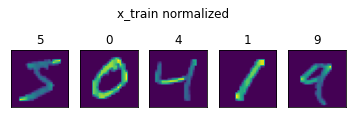

In [7]:
plot_example(x_train_norm, y_train)
plt.suptitle('x_train normalized', y=0.75)

## Plot Salt and Pepper Noise

Text(0.5, 0.75, 'X_train Salt and Pepper')

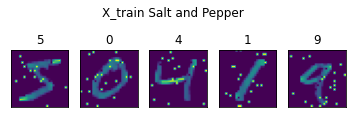

In [8]:
plot_example(x_train_sp, y_train)
plt.suptitle('X_train Salt and Pepper', y=0.75)

## Plot Gaussian noise

Text(0.5, 0.75, 'X_train Gaussian')

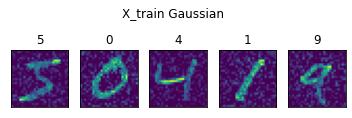

In [10]:
plot_example(x_train_gn, y_train)
plt.suptitle('X_train Gaussian', y=0.75)

### Model

In [11]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 16, 5, stride=2, padding=1),
            # nn.Conv2d(encoded_space_dim, 16, 5, stride=2, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(16, 32, 5, stride=2, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        
        ### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(32, 32),
            # nn.Linear(256, 16),
            nn.ReLU(True),
            nn.Linear(32, 16),
            nn.ReLU(True),
            nn.Linear(16, encoded_space_dim)
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x
    
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 5 * 5 * 28),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(28, 5, 5))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(28, 16, 5, stride=2, output_padding=1),
            # nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, 5, stride=2, padding=2, output_padding=1),
            # nn.BatchNorm2d(8),
            # nn.ReLU(True),
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

### Initialize Model

In [12]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001

### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
d = 4

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = Encoder(encoded_space_dim=d,fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=d,fc2_input_dim=128)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Selected device: cuda


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=700, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(28, 5, 5))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(28, 16, kernel_size=(5, 5), stride=(2, 2), output_padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 1, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
  )
)

### Functions for train, test, plotting

In [13]:

### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    epoch = 0
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        if epoch%10 == 0:
            print('\t partial train loss (single batch): %f' % (loss.data))
            epoch = epoch + 1
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

In [14]:

### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [15]:

def plot_ae_outputs(encoder,decoder,n=10):
    plt.figure(figsize=(16,4.5))
    targets = test_dataset.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    for i in range(n):
        ax = plt.subplot(2,n,i+1)
        img = test_dataset[t_idx[i]][0].unsqueeze(0).to(device)
        encoder.eval()
        decoder.eval()
        with torch.no_grad():
            rec_img  = decoder(encoder(img))
        plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('Original images')
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('Reconstructed images')
    plt.show()   

# Normal Recreation

	 partial train loss (single batch): 1.199105

 EPOCH 1/15 	 train loss 0.8591184020042419 	 val loss 0.7698227167129517


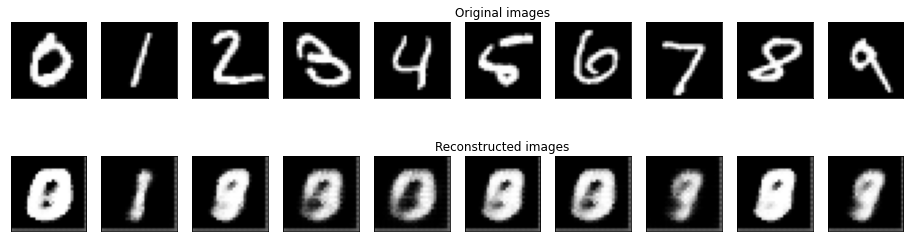

	 partial train loss (single batch): 0.744684

 EPOCH 2/15 	 train loss 0.716391921043396 	 val loss 0.6805979609489441


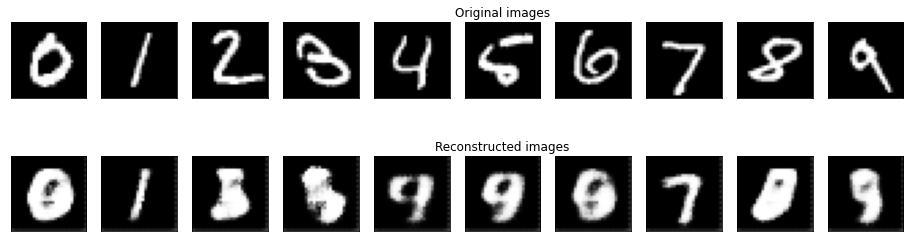

	 partial train loss (single batch): 0.662291

 EPOCH 3/15 	 train loss 0.6501230597496033 	 val loss 0.6441283822059631


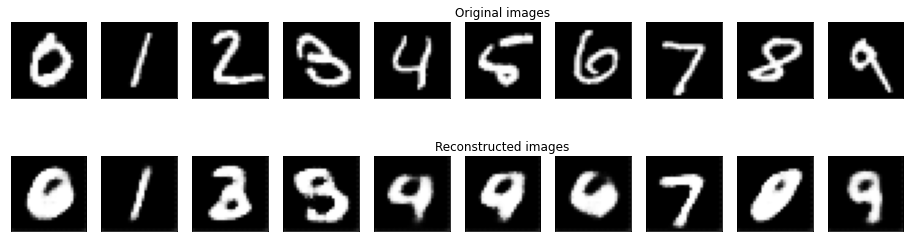

	 partial train loss (single batch): 0.624661

 EPOCH 4/15 	 train loss 0.6273584365844727 	 val loss 0.6314595937728882


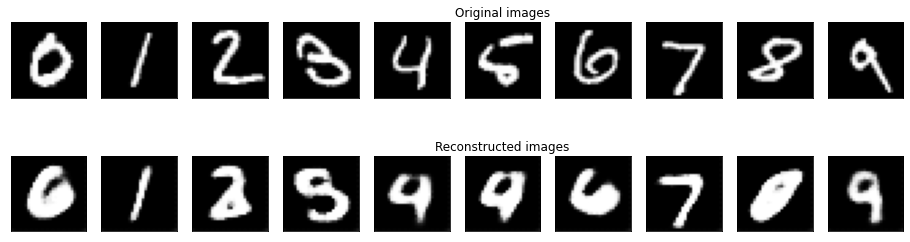

	 partial train loss (single batch): 0.610326

 EPOCH 5/15 	 train loss 0.617542028427124 	 val loss 0.6237572431564331


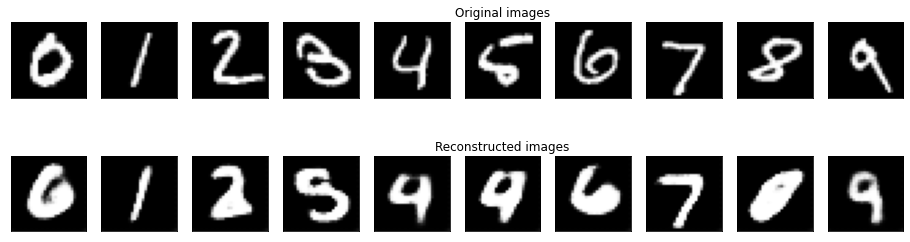

	 partial train loss (single batch): 0.602387

 EPOCH 6/15 	 train loss 0.6113377213478088 	 val loss 0.6191222667694092


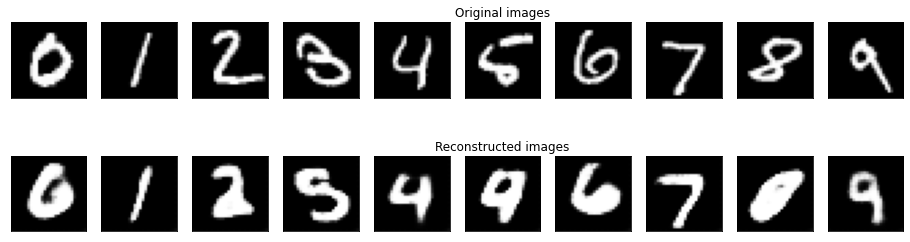

	 partial train loss (single batch): 0.597097

 EPOCH 7/15 	 train loss 0.6068970561027527 	 val loss 0.6160504221916199


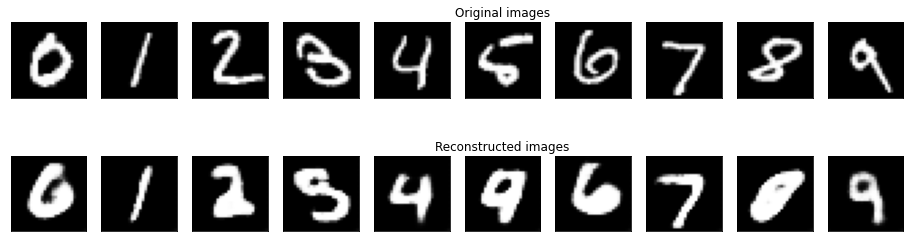

	 partial train loss (single batch): 0.593152

 EPOCH 8/15 	 train loss 0.6034591794013977 	 val loss 0.6125121116638184


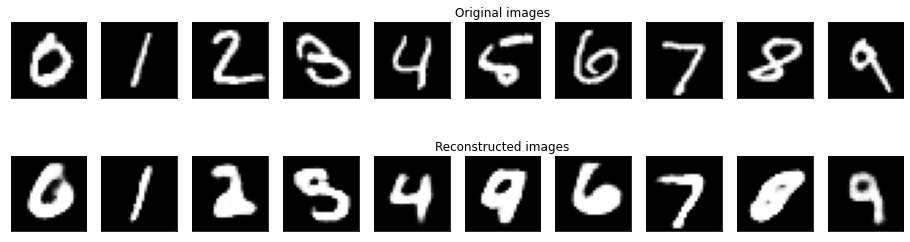

	 partial train loss (single batch): 0.588439

 EPOCH 9/15 	 train loss 0.6007372736930847 	 val loss 0.6106844544410706


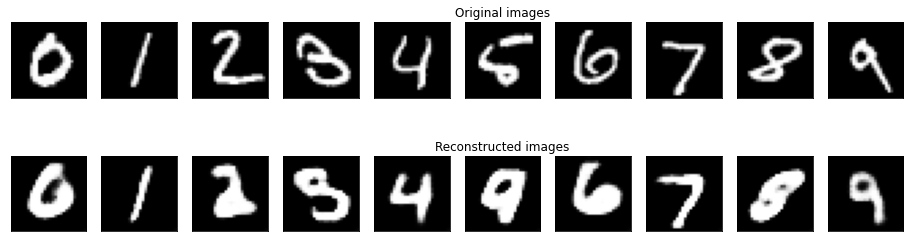

	 partial train loss (single batch): 0.585759

 EPOCH 10/15 	 train loss 0.5983826518058777 	 val loss 0.6080936789512634


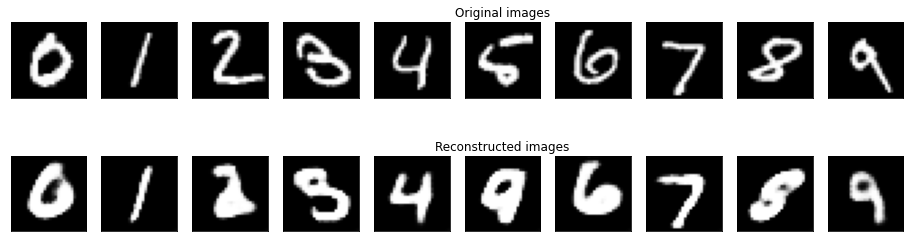

	 partial train loss (single batch): 0.582396

 EPOCH 11/15 	 train loss 0.5962912440299988 	 val loss 0.6062635183334351


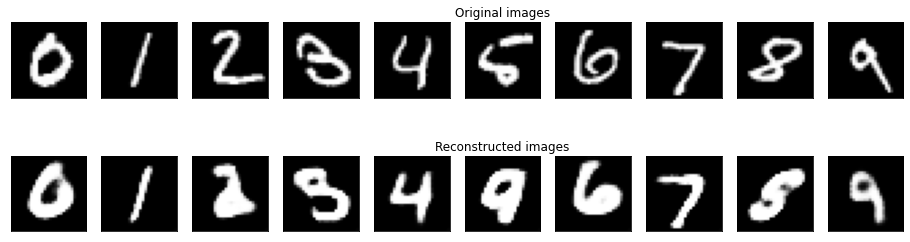

	 partial train loss (single batch): 0.579892

 EPOCH 12/15 	 train loss 0.5945221781730652 	 val loss 0.6052482724189758


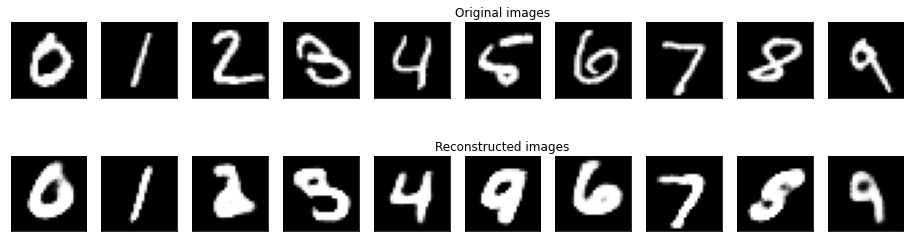

	 partial train loss (single batch): 0.578401

 EPOCH 13/15 	 train loss 0.5930488705635071 	 val loss 0.6034895181655884


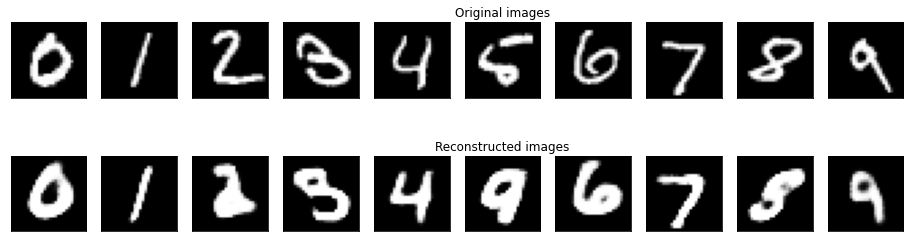

	 partial train loss (single batch): 0.576407

 EPOCH 14/15 	 train loss 0.5917179584503174 	 val loss 0.6027624011039734


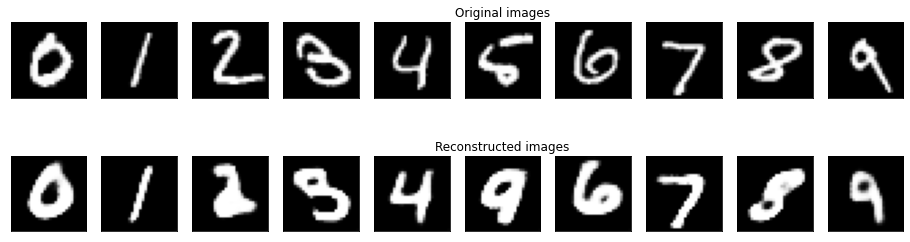

	 partial train loss (single batch): 0.575334

 EPOCH 15/15 	 train loss 0.5905380845069885 	 val loss 0.601186990737915


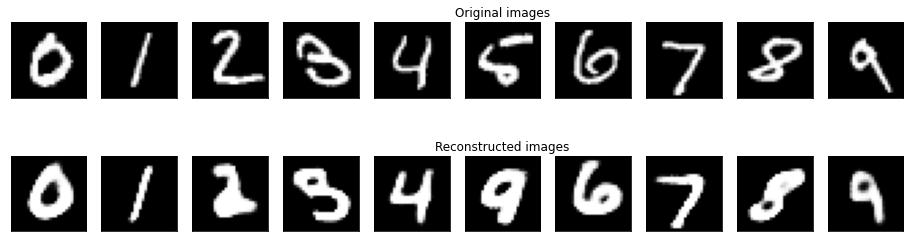

In [16]:
num_epochs = 15
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
    train_loss =train_epoch(encoder,decoder,device, train_loader,loss_fn,optim)
    val_loss = test_epoch(encoder,decoder,device, valid_loader,loss_fn)
    print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
    diz_loss['train_loss'].append(train_loss)
    diz_loss['val_loss'].append(val_loss)
    plot_ae_outputs(encoder,decoder,n=10)

### Test Error normal

In [18]:
test_epoch(encoder,decoder,device,test_loader,loss_fn).item()

0.5958901643753052

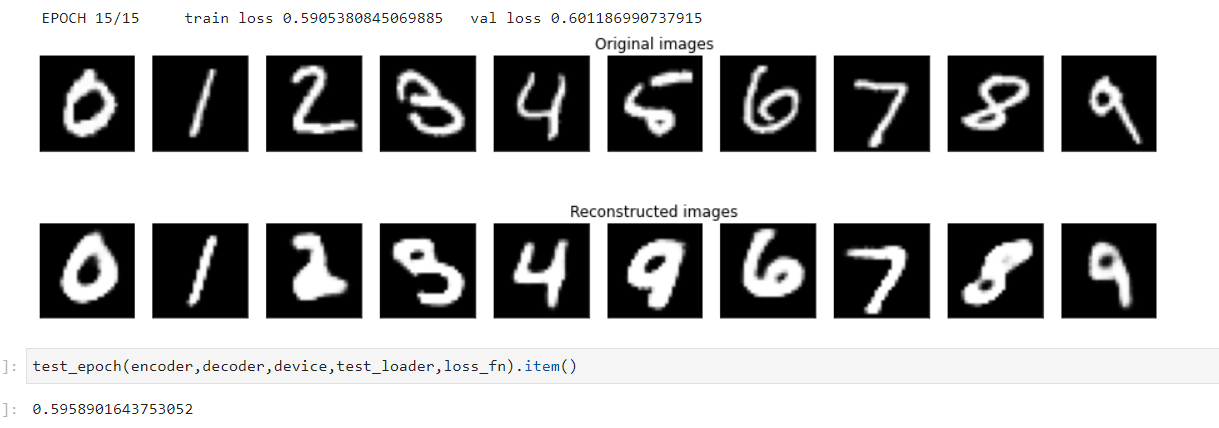

# Salt and Pepper Noise Recreation

In [19]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001

### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
d = 4

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = Encoder(encoded_space_dim=d,fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=d,fc2_input_dim=128)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Selected device: cuda


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=700, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(28, 5, 5))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(28, 16, kernel_size=(5, 5), stride=(2, 2), output_padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 1, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
  )
)

In [29]:
def add_sp_noise(inputs):
    noisy = skimage.util.random_noise(inputs, mode = 's&p')
    noisy = torch.Tensor(noisy)
    return noisy

In [30]:

### Training function
def train_epoch_sp(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    epoch = 0
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_noisy = add_sp_noise(image_batch)
        image_batch = image_batch.to(device)
        image_noisy = image_noisy.to(device) 
        # Encode data
        encoded_data = encoder(image_noisy)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        if epoch%10 == 0:
            print('\t partial train loss (single batch): %f' % (loss.data))
            epoch = epoch + 1
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

	 partial train loss (single batch): 1.199112

 EPOCH 1/15 	 train loss 0.8659313321113586 	 val loss 0.8204062581062317


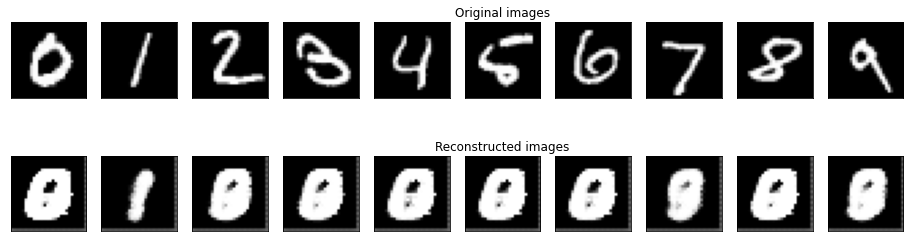

	 partial train loss (single batch): 0.761783

 EPOCH 2/15 	 train loss 0.731042742729187 	 val loss 0.740249752998352


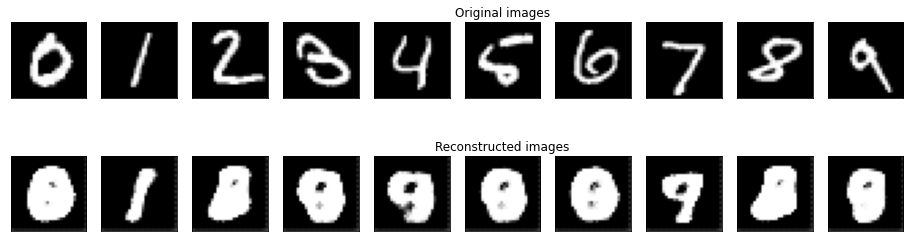

	 partial train loss (single batch): 0.684424

 EPOCH 3/15 	 train loss 0.6757731437683105 	 val loss 0.7214561104774475


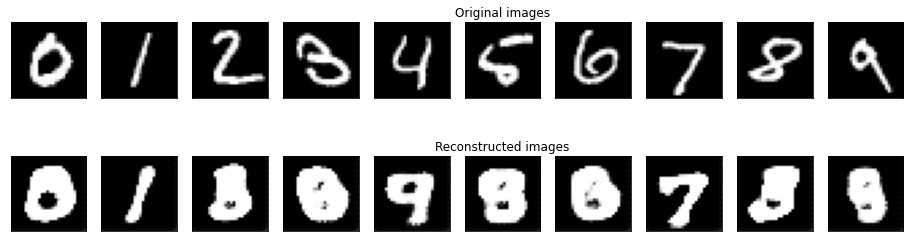

	 partial train loss (single batch): 0.642774

 EPOCH 4/15 	 train loss 0.6402817368507385 	 val loss 0.6879740357398987


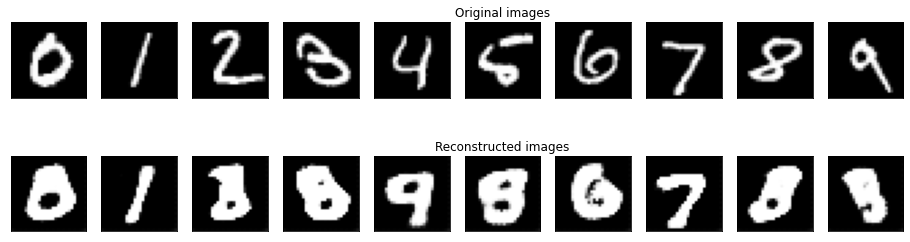

	 partial train loss (single batch): 0.613557

 EPOCH 5/15 	 train loss 0.6244199872016907 	 val loss 0.6845067143440247


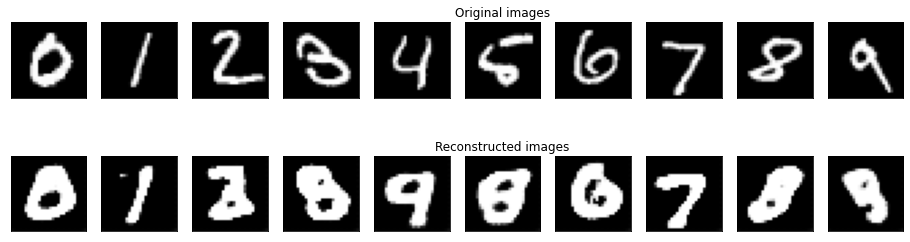

	 partial train loss (single batch): 0.601616

 EPOCH 6/15 	 train loss 0.6153585314750671 	 val loss 0.6908174753189087


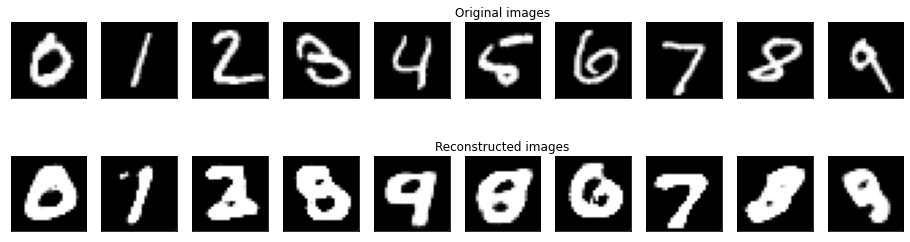

	 partial train loss (single batch): 0.593233

 EPOCH 7/15 	 train loss 0.6096193194389343 	 val loss 0.6910345554351807


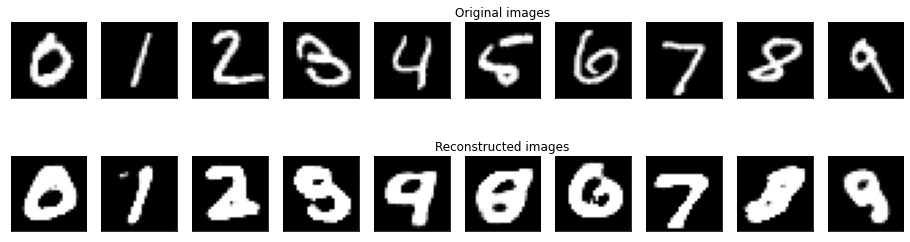

	 partial train loss (single batch): 0.592831

 EPOCH 8/15 	 train loss 0.6056206822395325 	 val loss 0.6948915719985962


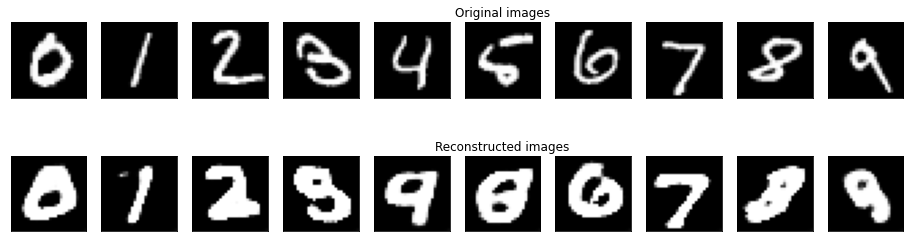

	 partial train loss (single batch): 0.590154

 EPOCH 9/15 	 train loss 0.6026974320411682 	 val loss 0.7043923735618591


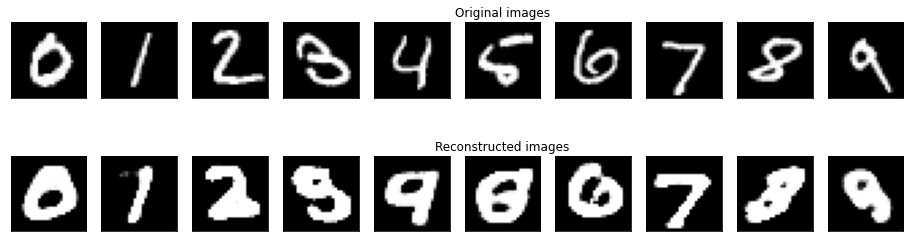

	 partial train loss (single batch): 0.586149

 EPOCH 10/15 	 train loss 0.6003457307815552 	 val loss 0.7072591185569763


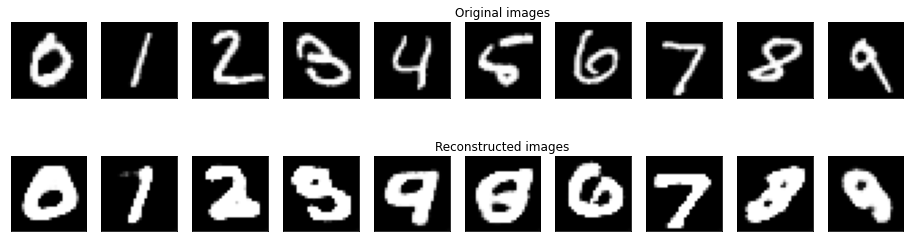

	 partial train loss (single batch): 0.582488

 EPOCH 11/15 	 train loss 0.5984859466552734 	 val loss 0.7076078057289124


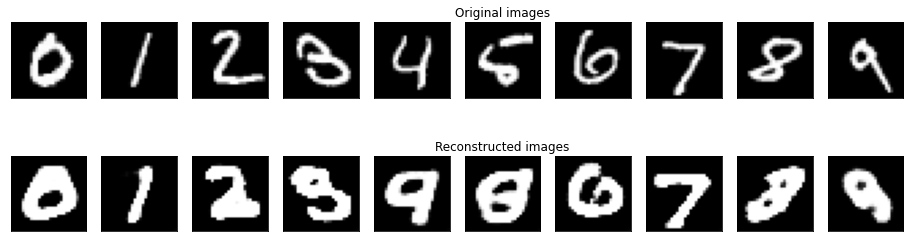

	 partial train loss (single batch): 0.581306

 EPOCH 12/15 	 train loss 0.5969406962394714 	 val loss 0.7092469334602356


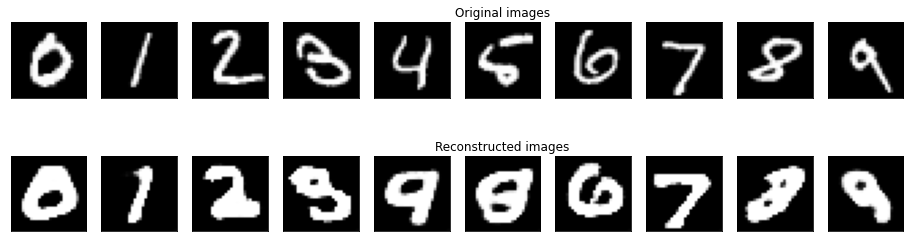

	 partial train loss (single batch): 0.580282

 EPOCH 13/15 	 train loss 0.5956377983093262 	 val loss 0.7156817317008972


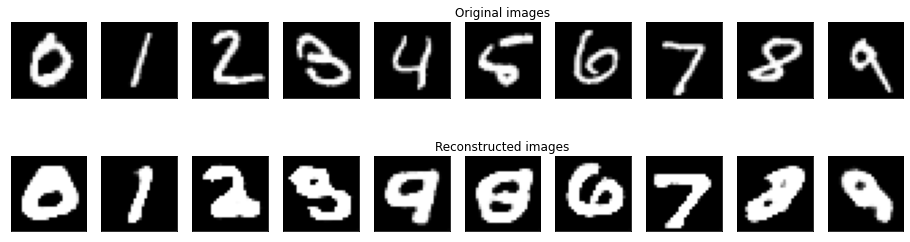

	 partial train loss (single batch): 0.577033

 EPOCH 14/15 	 train loss 0.594403862953186 	 val loss 0.7215543389320374


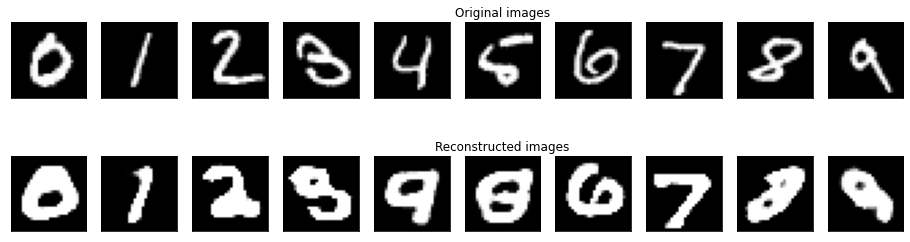

	 partial train loss (single batch): 0.576143

 EPOCH 15/15 	 train loss 0.5934213399887085 	 val loss 0.7179720401763916


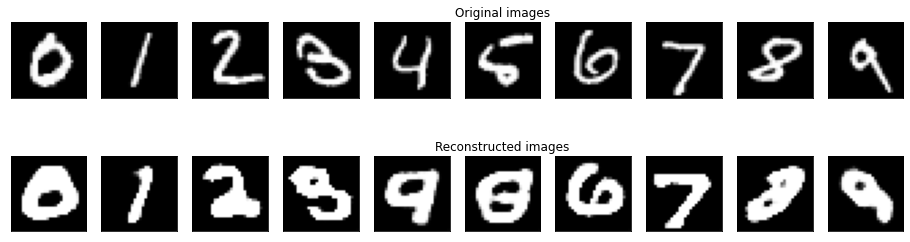

In [31]:
num_epochs = 15
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
    train_loss =train_epoch_sp(encoder,decoder,device, train_loader,loss_fn,optim)
    val_loss = test_epoch(encoder,decoder,device,valid_loader,loss_fn)
    print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
    diz_loss['train_loss'].append(train_loss)
    diz_loss['val_loss'].append(val_loss)
    plot_ae_outputs(encoder,decoder,n=10)

### Test Error s&p

In [33]:
test_epoch(encoder,decoder,device,test_loader,loss_fn).item()

0.7148679494857788

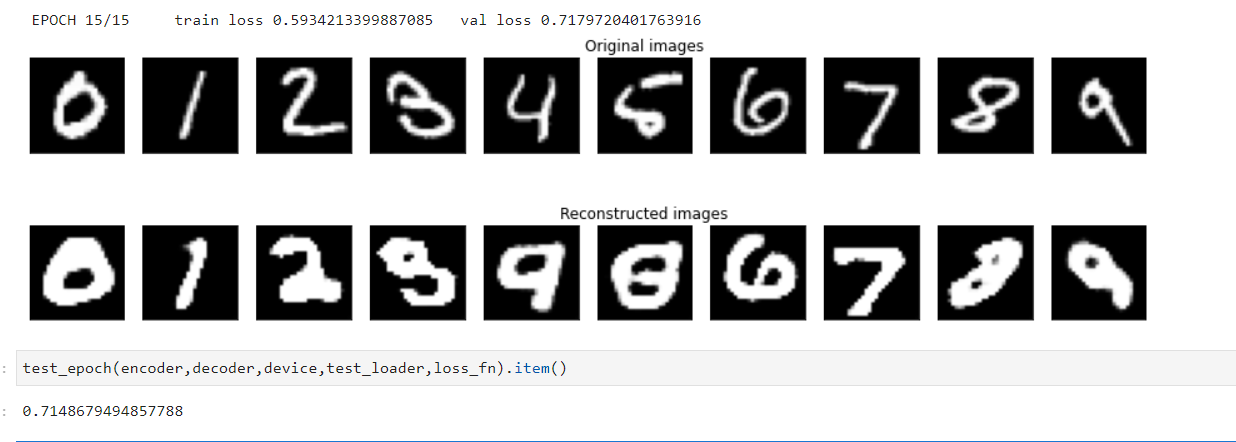

# Gaussian Noise Recreation

In [34]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001

### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
d = 4

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = Encoder(encoded_space_dim=d,fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=d,fc2_input_dim=128)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Selected device: cuda


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=700, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(28, 5, 5))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(28, 16, kernel_size=(5, 5), stride=(2, 2), output_padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 1, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
  )
)

In [35]:
def add_gn_noise(inputs):
    noisy = skimage.util.random_noise(inputs, mode = 'gaussian')
    noisy = torch.Tensor(noisy)
    return noisy

In [36]:
### Training function
def train_epoch_gn(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    epoch = 0
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_noisy = add_gn_noise(image_batch)
        image_batch = image_batch.to(device)
        image_noisy = image_noisy.to(device) 
        # Encode data
        encoded_data = encoder(image_noisy)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        if epoch%10 == 0:
            print('\t partial train loss (single batch): %f' % (loss.data))
            epoch = epoch + 1
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

	 partial train loss (single batch): 1.199112

 EPOCH 1/15 	 train loss 0.8640114665031433 	 val loss 0.8060108423233032


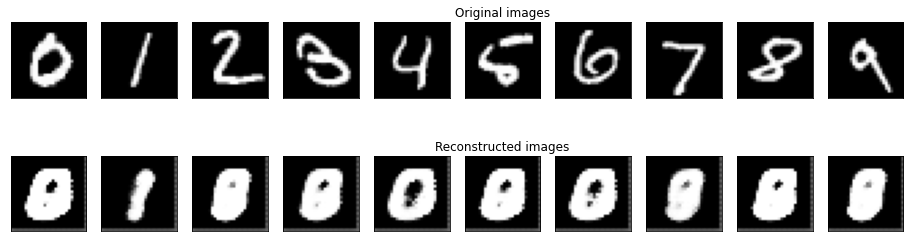

	 partial train loss (single batch): 0.749543

 EPOCH 2/15 	 train loss 0.7208108305931091 	 val loss 0.7315411567687988


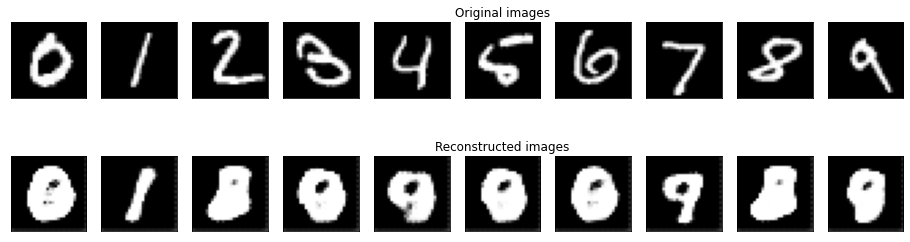

	 partial train loss (single batch): 0.681876

 EPOCH 3/15 	 train loss 0.6803053021430969 	 val loss 0.7317110300064087


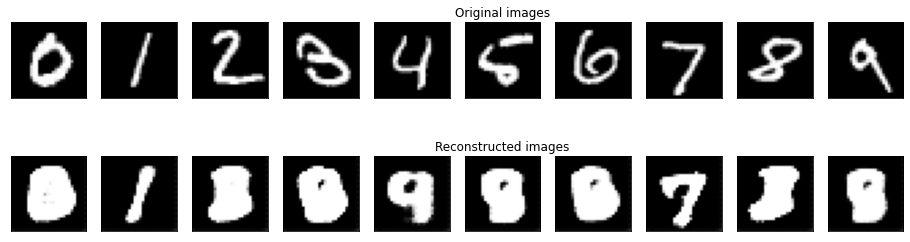

	 partial train loss (single batch): 0.653977

 EPOCH 4/15 	 train loss 0.6502658724784851 	 val loss 0.7010879516601562


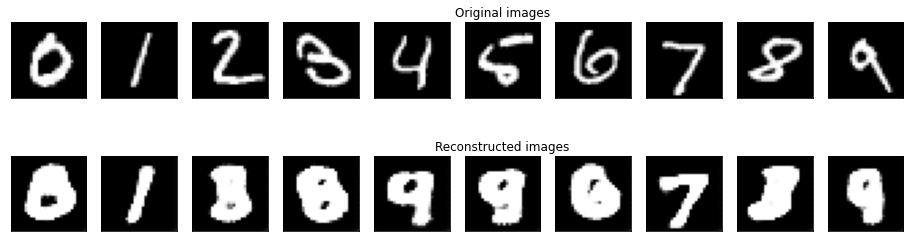

	 partial train loss (single batch): 0.625735

 EPOCH 5/15 	 train loss 0.6290314197540283 	 val loss 0.6953105926513672


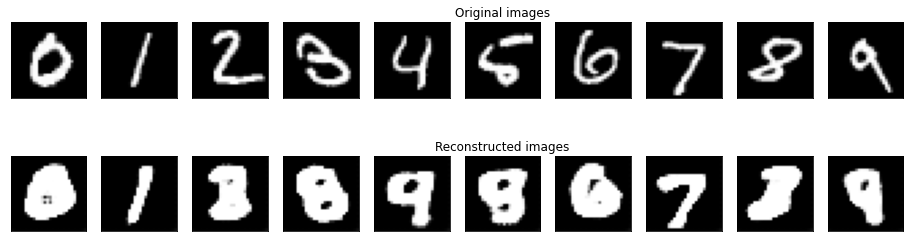

	 partial train loss (single batch): 0.610975

 EPOCH 6/15 	 train loss 0.618095338344574 	 val loss 0.6940616369247437


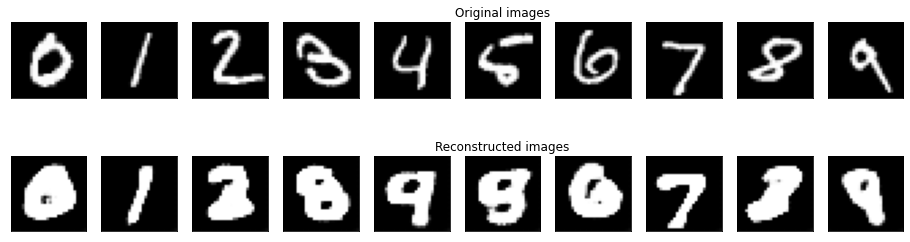

	 partial train loss (single batch): 0.603202

 EPOCH 7/15 	 train loss 0.6109798550605774 	 val loss 0.6942742466926575


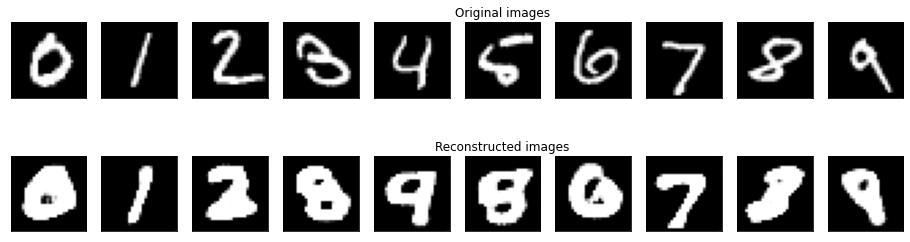

	 partial train loss (single batch): 0.597411

 EPOCH 8/15 	 train loss 0.6060182452201843 	 val loss 0.6980619430541992


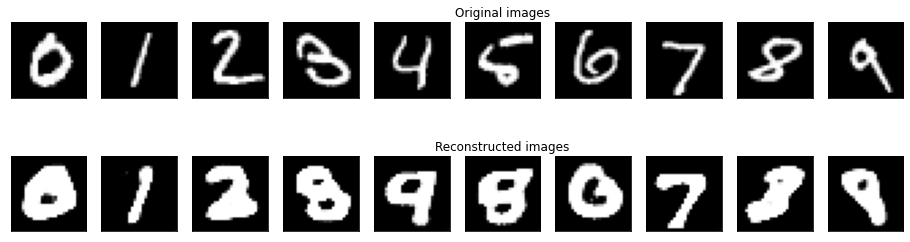

	 partial train loss (single batch): 0.592950

 EPOCH 9/15 	 train loss 0.6023976802825928 	 val loss 0.7019633650779724


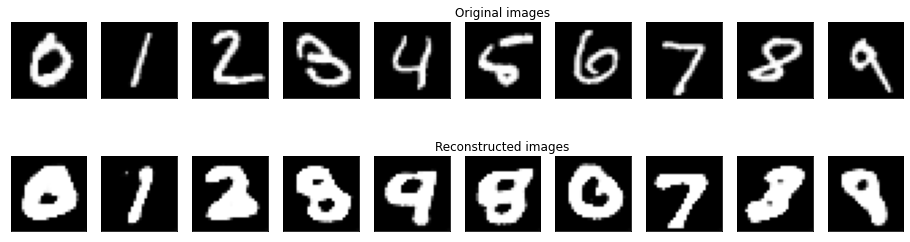

	 partial train loss (single batch): 0.589716

 EPOCH 10/15 	 train loss 0.5995023250579834 	 val loss 0.7035889625549316


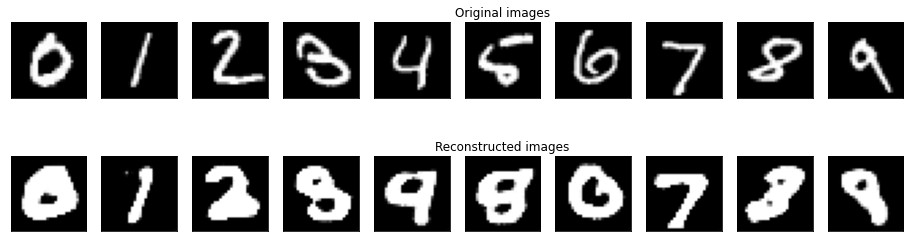

	 partial train loss (single batch): 0.586112

 EPOCH 11/15 	 train loss 0.5970669984817505 	 val loss 0.707734227180481


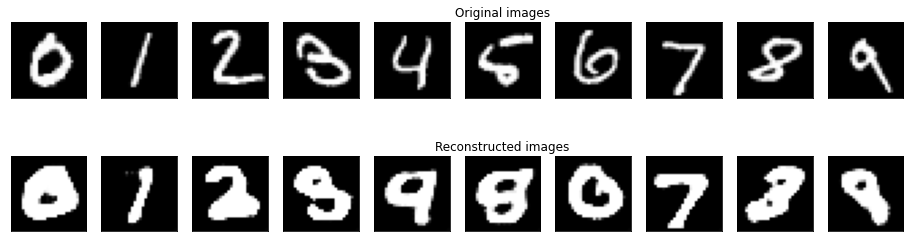

	 partial train loss (single batch): 0.582511

 EPOCH 12/15 	 train loss 0.5950100421905518 	 val loss 0.7078014612197876


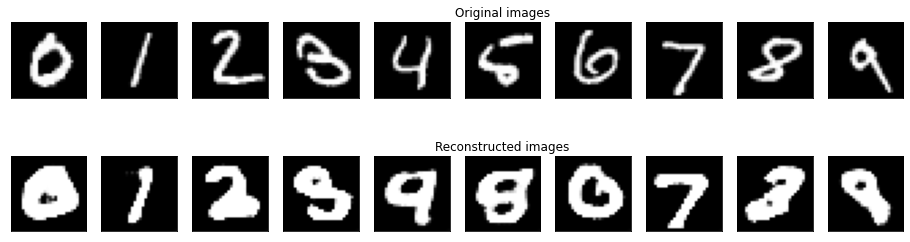

	 partial train loss (single batch): 0.578889

 EPOCH 13/15 	 train loss 0.5933055877685547 	 val loss 0.7084773182868958


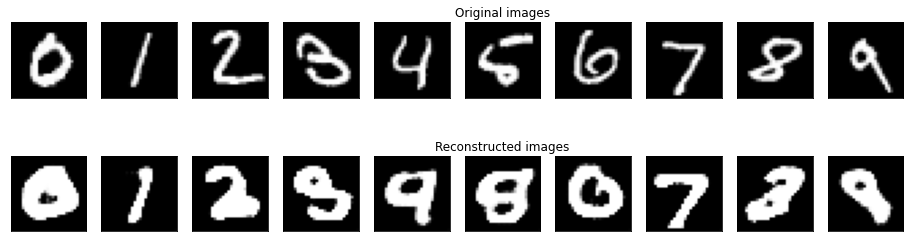

	 partial train loss (single batch): 0.575792

 EPOCH 14/15 	 train loss 0.5918759703636169 	 val loss 0.7114432454109192


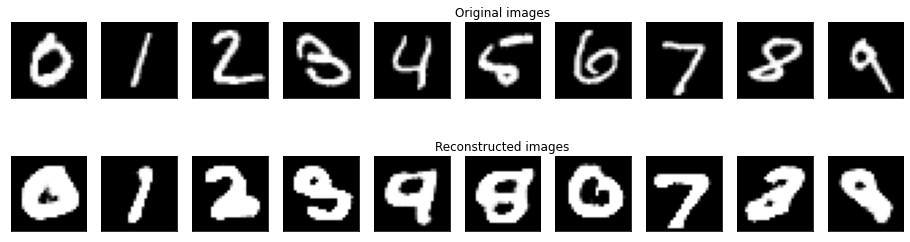

	 partial train loss (single batch): 0.573075

 EPOCH 15/15 	 train loss 0.590705394744873 	 val loss 0.711957573890686


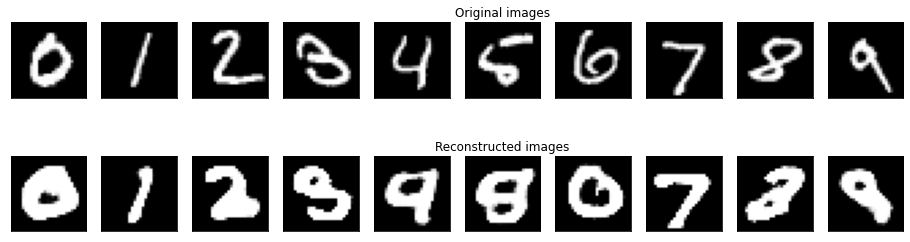

In [37]:
num_epochs = 15
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
    train_loss =train_epoch_gn(encoder,decoder,device, train_loader,loss_fn,optim)
    val_loss = test_epoch(encoder,decoder,device,valid_loader,loss_fn)
    print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
    diz_loss['train_loss'].append(train_loss)
    diz_loss['val_loss'].append(val_loss)
    plot_ae_outputs(encoder,decoder,n=10)

### Test error gaussian

In [38]:
test_epoch(encoder,decoder,device,test_loader,loss_fn).item()

0.709566593170166

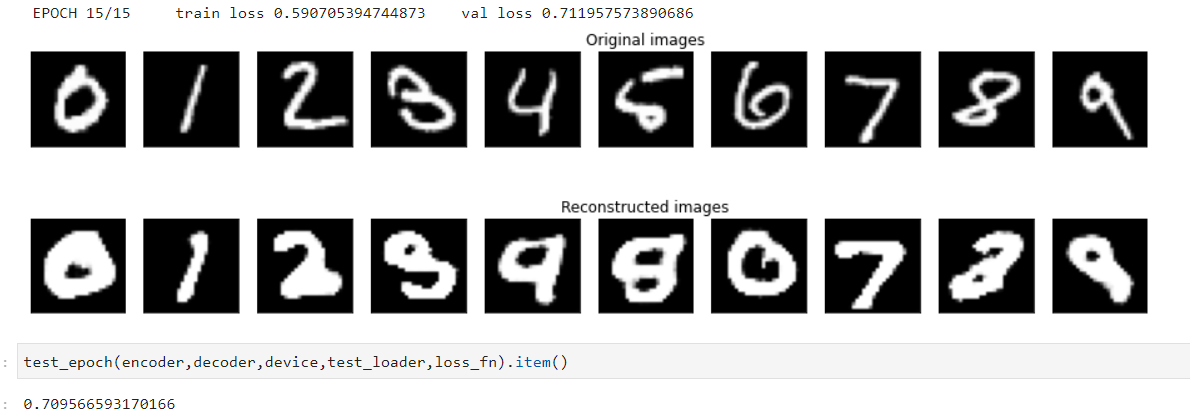